# Atividade 6

Planejamento de Sistemas Elétricos - PPEE

Aluno: Alexandre Soares Altgott

Matrícula: 102100645

In [ ]:
!pip install PySDDP

In [1]:
from google.colab import drive, files
import os

#Montar o Google Drive no Colab com o nome gdrive

drive.mount('/content/gdrive')

# O comando abaixo mostra qual diretório você está trabalhando momento.
print( os.getcwd() )

Caminho_do_Arquivo = 'gdrive/My Drive/NewaveJuly2023/'
# O comando mostra o que está presente dentro da minha pasta GIF no meu drive, que está dentro do meu drive e em Doutorado. Mudar para o diretório que vocês criaram.
print( os.listdir(Caminho_do_Arquivo) )

['ADTERM.DAT', 'AGRINT.DAT', 'ARQUIVOS.DAT', 'BID.DAT', 'CASO.DAT', 'CDEFVAR.DAT', 'CLAST.DAT', 'CONFHD.DAT', 'CONFT.DAT', 'CURVA.DAT', 'CVAR.DAT', 'C_ADIC.DAT', 'DGER.DAT', 'DSVAGUA.DAT', 'ELNINO.DAT', 'ENSOAUX.DAT', 'EXPH.DAT', 'EXPT.DAT', 'FORMAT.TMP', 'GHMIN.DAT', 'GTMINPAT.DAT', 'GTMIN_CCEE_072023.xlsx', 'HIDR.DAT', 'ITAIPU.DAT', 'LOSS.DAT', 'MANUTT.DAT', 'MENSAG.TMP', 'MODIF.DAT', 'NewaveMsgPortug.txt', 'PATAMAR.DAT', 'PENALID.DAT', 'POSTOS.DAT', 'RE.DAT', 'REE.DAT', 'selcor.dat', 'SHIST.DAT', 'SISTEMA.DAT', 'tecno.dat', 'TERM.DAT', 'VAZOES.DAT', 'VAZPAST.DAT']


In [2]:
from PySDDP.Pen import Newave

PMOSET2023 = Newave(Caminho_do_Arquivo)

OK! Leitura do CASO.DAT realizada com sucesso.
OK! Leitura do ARQUIVOS.DAT realizada com sucesso.
OK! Leitura do DGER.DAT realizada com sucesso.
OK! Leitura do HIDR.DAT realizada com sucesso.
OK! Leitura do VAZOES.DAT realizada com sucesso.
OK! Leitura do MODIF.DAT realizada com sucesso. ( 99 Usinas Hidraulicas Modificadas )
OK! Leitura do EXPH.DAT realizada com sucesso. ( 2 Usinas Hidraulicas Expandidas )
OK! Leitura do CONFHD.DAT realizada com sucesso.
OK! Leitura do REE.DAT realizada com sucesso. ( 12 Reservatórios Equivalentes de Energia Foram Lidos )
OK! Leitura do SISTEMA.DAT realizada com sucesso.


In [3]:
Usina = PMOSET2023.confhd.get('Itauba')

## Modelo de Otimização para o Problema Analisado

Para o caso exemplo do mês de agosto a ser estimado a vazão

$Min \hspace{0.5cm} \varepsilon_{ago,1931}^2 + \varepsilon_{ago,1932}^2  + ... + \varepsilon_{ago,2020}^2  + \varepsilon_{ago,2021}^2  $

Sujeito a:

$Z_{ago,1932} = \phi_1 \cdot Z_{jul,1932} + \phi_2 \cdot Z_{jun,1932} + ... +  \phi_n \cdot Z_{n,1932}  + \varepsilon_{mar,1932}^2  $

$Z_{ago,1933} = \phi_1 \cdot Z_{jul,1933} + \phi_2 \cdot Z_{jun,1933} + ... +  \phi_n \cdot Z_{n,1933}  + \varepsilon_{mar,1933}^2  $

.

.

.

$Z_{ago,2021} = \phi_1 \cdot Z_{jul,2021} + \phi_2 \cdot Z_{jun,2021} + ... +  \phi_n \cdot Z_{n,2021}  + \varepsilon_{mar,2021}^2  $

## Função do Modelo Auto-Regressivo

In [4]:
from cvxopt import matrix, solvers
import numpy as np


def modelo_autoregressivo(Usina, AnoAnalisado, N_meses, Mes_analisado,imprime = False):
    """
    Função que estima as vazões de um mês a partir de uma série de vazões de anos anteriores utilizando um modelo auto regressivo.
    """


    # Retira o ultimo e o primeiro ano e considera que a contagem começa em zero
    N_anos = len(Usina['vazoes']) - 3

    # AnoAnalisado = AnoAnalisado - 2021 + N_anos + 2

    if Mes_analisado - N_meses >= 0:

        recorte = Usina['vazoes'][1:N_anos+1,(Mes_analisado-N_meses):Mes_analisado]

        recorte = recorte[:, ::-1]

    else:

        recorteAnoAtual = Usina['vazoes'][1:N_anos+1,0:Mes_analisado]

        recorteAnoAtual = recorteAnoAtual[:, ::-1]

        recorteAnoAnt = Usina['vazoes'][0:N_anos,(Mes_analisado-N_meses):]

        recorteAnoAnt = recorteAnoAnt[:, ::-1]

        recorte = np.concatenate((recorteAnoAnt,recorteAnoAtual),axis=1)

        

    
    identidade = np.eye(N_anos)

    soma_zero = np.ones((N_anos+N_meses))

    for i in range(0,N_meses):
        soma_zero[i] = 0



    Aeq = np.concatenate((recorte, identidade), axis = 1)
    Aeq = np.vstack((Aeq, soma_zero))
    # Aeq = Aeq.astype('float')
    Aeq = matrix(Aeq)*1.0

    Beq = Usina['vazoes'][1:N_anos+1,Mes_analisado:Mes_analisado+1].copy()
    # Beq = Usina['vazoes'][1:N_anos+1,Mes_analisado].copy()
    Beq = np.vstack((Beq, [0]))
    # Beq = Beq.astype('float')
    Beq = matrix(Beq)*1.0

    q = matrix(np.zeros(N_anos+N_meses))

    P = 2*np.eye(N_anos+N_meses)
    for i in range(0,N_meses):
        P[i][i] = 1*10**(-6)
    P = matrix(P)




    A = np.vstack((-1*np.eye(N_anos+N_meses), np.eye(N_anos+N_meses)))
    A = A.astype('float')
    A = matrix(A)
    B = 99999*np.ones(((N_anos+N_meses)*2,1))

    B = B.astype('float')
    B = matrix(B)



    solvers.options['show_progress'] = False
    abstol = 1e-9
    reltol = 1e-9
    sol = solvers.qp(P, q, A, B, Aeq, Beq)

    

    fob = 0
    for i in sol['x'][N_meses:]:
        fob += i**2



    if Mes_analisado - N_meses >= 0:
        
        soma = 0

        for i, v in enumerate(Usina['vazoes'][AnoAnalisado,(Mes_analisado-N_meses):Mes_analisado]):
            
            soma += v*sol['x'][N_meses-i-1]

    else:

        soma = 0

        for i, v in enumerate(Usina['vazoes'][AnoAnalisado,0:Mes_analisado]):

            soma += v*sol['x'][N_meses-i-1]

        for i, v in enumerate(Usina['vazoes'][AnoAnalisado-1,(Mes_analisado-N_meses):]):

            soma += v*sol['x'][N_meses-Mes_analisado-i-1]

    if imprime:

        print(f'Vazão estimada para o mês {Mes_analisado}: {soma} hm^3')

    return [fob,soma,sol['x']]




    
        


## Programa Principal

In [5]:
anos_retirados = 0

In [6]:
# Excluir anos mais recentes caso queira
Usina['vazoes'] = Usina['vazoes'][:-2]
anos_retirados += 2

A vazão estimada para o mês 7, considerando os 3 últimos meses para o cálculo, é de: 173.0352676019856 m³/s


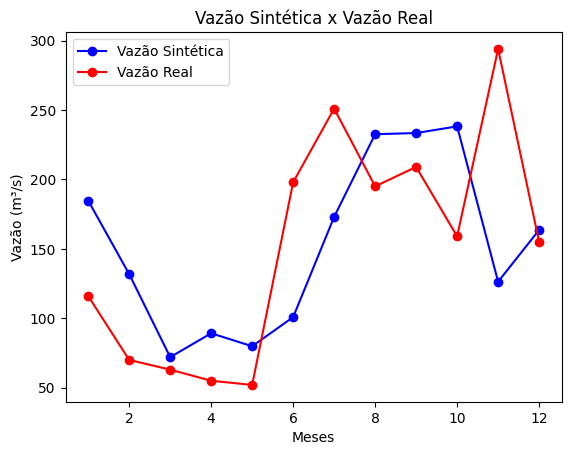

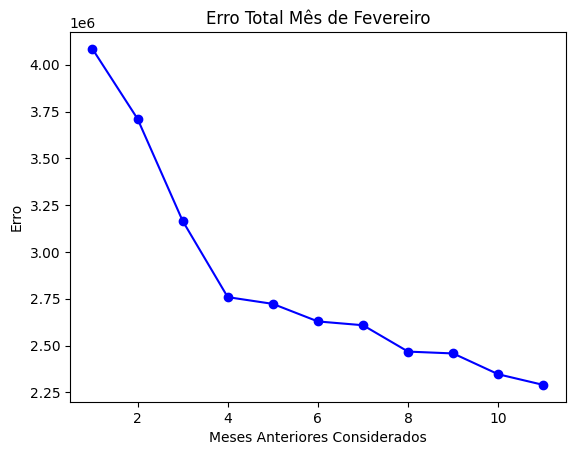

In [7]:
from cvxopt import matrix, solvers
from matplotlib import pyplot as plt



# Ano a ser analisado
AnoAnalisado = 2010

# Numero de meses anteriores a serem considerados
N_meses = 3

# Numero do mes considerando janeiro zero
Mes_analisado = 6

# Retira o ultimo e o primeiro ano e considera que a contagem começa em zero
N_anos = len(Usina['vazoes']) - 3

# Converte o ano para o indice da lista
AnoAnalisado = AnoAnalisado - 2023 - anos_retirados + N_anos + 2


print(f'A vazão estimada para o mês {Mes_analisado + 1}, considerando os {N_meses} últimos meses para o cálculo, é de: {modelo_autoregressivo(Usina, AnoAnalisado, N_meses, Mes_analisado)[1]} m³/s')

resultado = []
fob = []

for i in range(0,12):

    resposta = modelo_autoregressivo(Usina, AnoAnalisado, N_meses, i)
    resultado.append(resposta[1])


for i in range(1,12):

    resposta = modelo_autoregressivo(Usina, AnoAnalisado, i, Mes_analisado)
    fob.append(resposta[0])

    





plt.figure()
plt.title("Vazão Sintética x Vazão Real")
plt.xlabel("Meses")
plt.ylabel("Vazão (m³/s)")
plt.plot(list(range(1,13)),resultado,marker="o",color="blue",label="Vazão Sintética")
plt.plot(list(range(1,13)),Usina['vazoes'][AnoAnalisado],marker="o",color="red",label="Vazão Real")
plt.legend()


plt.figure()
plt.title("Erro Total Mês de Fevereiro")
plt.xlabel("Meses Anteriores Considerados")
plt.ylabel("Erro")
plt.plot(list(range(1,12)),fob,marker="o",color="blue")



## Plot do Erro por Meses Anteriores Vistos e Mês Analisado

Aqui é plotado o erro ao se variar o mês analisado (de janeiro a dezembro) e quantos meses anteriores (de 1 a 12) se olha para mostrar se há meses com estimações mais erroneas e como a quantidades de meses anteriores que se considera impactam no erro. 

Como mostra o gráfico, os meses do meio do ano possuem um erro menor, assim como ao se olhar para mais meses anteriores há um tendência de melhores resultados.

C:\Users\alexa\AppData\Local\Temp\ipykernel_14772\2031315294.py:25: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 12


Text(0.5, 0.92, 'Erro por Meses Anteriores Vistos e Mês Analisado')

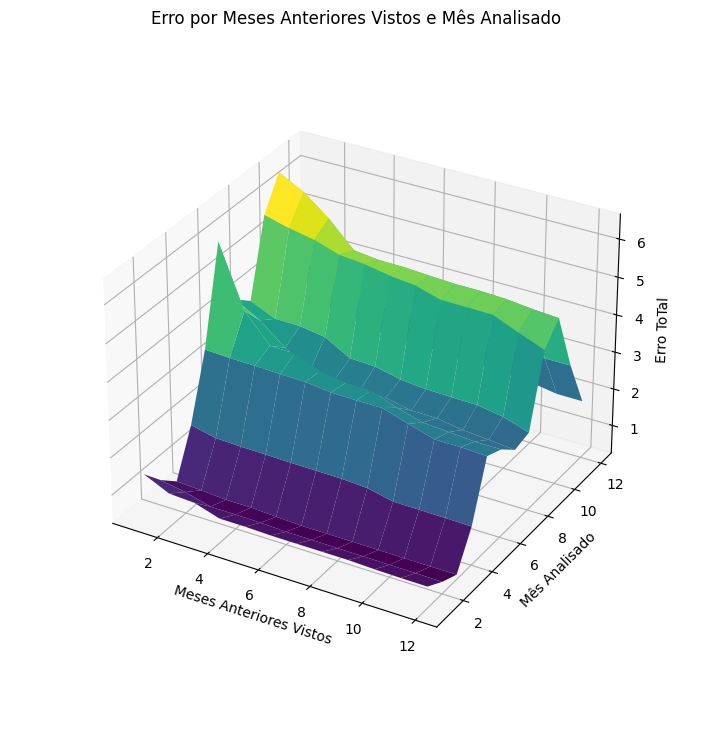

In [8]:
size = 12
default_value = []


resultado = []
resultado.extend([default_value] * size)
for i in range(0,12):
    resultado[i] = []
    resultado[i].extend([default_value] * 12)


for i in range(0,12):
    for j in range(1,13):
        resposta = modelo_autoregressivo(Usina, AnoAnalisado, j, i)
        resultado[i][j-1] = resposta[0]

x = np.linspace(1, 12, 12)
y = np.linspace(1, 12, 12)
x, y = np.meshgrid(x, y)

resultado = np.array(resultado)

fig = plt.figure(figsize=(14, 9))
ax = fig.add_subplot(111, projection='3d')
ax.dist = 12

# Plotar a superfície
surf = ax.plot_surface(x, y, resultado, cmap='viridis')

ax.set_xlabel('Meses Anteriores Vistos')
ax.set_ylabel('Mês Analisado')
ax.set_zlabel('Erro ToTal')
plt.title('Erro por Meses Anteriores Vistos e Mês Analisado')

In [9]:
def retorna_media(Usina):
    """
    Função que retorna a média das vazões de cada mês de um conjunto de dados de vazões.
    """

    media_vazao = []
    
    for j in range(0,12):

        media_vazao.append(0)

        for i, v in enumerate(Usina['vazoes']):     

            media_vazao[j] += v[j]

        media_vazao[j] = media_vazao[j]/len(Usina['vazoes'])    

    return media_vazao



In [10]:

def selecao_ordem(Usina):
    """
    Função que retorna a melhor ordem e a matriz de residuos do modelo auto regressivo para cada mês de um conjunto de dados de vazões.
    """

    # Cria os vetores que vão armazenar os resultados
    melhor_sol = []
    melhor_num_meses = []
    matriz_residuos = []
    phi = []

    # Loop externo de mês analisado
    for i in range(0,12):

        melhor_sol.append(float('inf'))
        melhor_num_meses.append(0)
        matriz_residuos.append(0)
        phi.append(0)

        # Loop interno de meses anteriores avaliados
        for j in range(1,12):

            # Roda o modelo auto regressivo
            resposta = modelo_autoregressivo(Usina, 1, j, i)

            # Verifica se o resultado é melhor que o anterior
            if resposta[0] < melhor_sol[i]:
                melhor_sol[i] = resposta[0]
                melhor_num_meses[i] = j
                matriz_residuos[i] = resposta[2][j:]
                phi[i] = resposta[2][:j]

    return melhor_num_meses,matriz_residuos,phi


In [11]:
import random


def gerar_serie(Usina, AnoAnalisado, mes_atual, num_series, num_anos, melhor_num_meses, matriz_residuos, phi, serie_aleatoria=False,plot_real=False,plot_exp=False):
    """
    Função que gera séried sintéticad de vazões a partir de um conjunto de dados de vazões.
    """

    ano = []

    # Loop esterno de anos
    for l in range(0,num_anos):
        ano.append(0)
        serie = []

        # O primeiro é gerado a partir de dados de entrada, logo é diferente dos demais
        if l == 0:
            
            # Loop interno de séries
            for i in range(0,num_series):
                serie.append([])
                
                # Se for definido como aleatório, utiliza uma série aleatória como dado de entrada
                if serie_aleatoria:
                    if mes_atual == 0:
                        vazao = random.choice(Usina['vazoes'])
                    else:
                        vazao = []
                        vazao.append(random.choice(Usina['vazoes']))
                        vazao.append(random.choice(Usina['vazoes']))

                # Se não, utiliza a série de entrada
                else:
                    if mes_atual == 0:
                        vazao = Usina['vazoes'][AnoAnalisado].copy()
                    else:
                        vazao = []
                        vazao.append(Usina['vazoes'][AnoAnalisado].copy())
                        vazao.append(Usina['vazoes'][AnoAnalisado-1].copy())

                for j in range(0,12):
                    serie[i].append(0)

                # Loop interno de meses
                for j in range(mes_atual,12):
                    
                    Z = 0

                    # Se o número de phis for maior que o mês atual analisado, neste caso utiliza a vazão do ano atual e do anterior
                    if j - melhor_num_meses[j] < 0:
                        
                        # Caso a série comece em janeiro
                        if mes_atual == 0:

                            # Soma a vazão do mês atual o respectivo phi vezes a vazão do ano anterior
                            for k, v in enumerate(vazao[j- melhor_num_meses[j]:]):
                                Z += phi[j][melhor_num_meses[j]-j-k-1]*v

                            # Soma a vazão do mês atual o respectivo phi vezes a vazão do ano atual
                            for k, v in enumerate(serie[i][0:j]):
                                Z += phi[j][melhor_num_meses[j]-k-1]*v

                        # Caso a série não comece em janeiro
                        else:

                            # Soma a vazão do mês atual o respectivo phi vezes a vazão do ano anterior
                            for k, v in enumerate(vazao[0][j- melhor_num_meses[j]:]):
                                Z += phi[j][melhor_num_meses[j]-j-k-1]*v

                            # Soma a vazão do mês atual o respectivo phi vezes a vazão do ano atual
                            for k, v in enumerate(vazao[-1][0:j]):
                                Z += phi[j][melhor_num_meses[j]-k-1]*v


                    # Se o número de phis for menor ou igual que o mês atual analisado, neste caso só utiliza a vazão do ano atual
                    else:

                        # Caso a série comece em janeiro
                        if mes_atual == 0:

                            # Soma a vazão do mês atual o respectivo phi vezes a vazão
                            for k, v in enumerate(serie[i][(j-melhor_num_meses[j]):j]):
                                Z += phi[j][melhor_num_meses[j]-k-1]*v

                        # Caso a série não comece em janeiro
                        else:

                            # Soma a vazão do mês atual o respectivo phi vezes a vazão
                            for k, v in enumerate(vazao[-1][(j-melhor_num_meses[j]):]):
                                Z += phi[j][melhor_num_meses[j]-k-1]*v

                    # Soma o resíduo à vazão sintética gerada
                    Z += random.choice(matriz_residuos[j])

                    # Atribui a vazão sintética gerada à série
                    serie[i][j] = Z

                    # Caso a série não comece em janeiro define o historico da série como a vazão de entrada
                    if mes_atual != 0:
                        for h in range(len(serie[i])):
                            if serie[i][h] == 0:
                                serie[i][h] = vazao[-1][h]

            # Atribui a série gerada ao ano
            ano[l] = serie.copy()

        # Para os demais anos
        else:

            # Loop interno de séries
            for i in range(0,num_series):

                serie.append([])

                # Loop interno de meses
                for j in range(0,12):

                    serie[i].append(0)

                    # A vazão de dados de entrada é a série gerada no ano anterior
                    vazao = ano[l-1][i].copy()

                    Z = 0

                    # Se o número de phis for maior que o mês atual analisado, neste caso utiliza a vazão do ano atual e do anterior
                    if j - melhor_num_meses[j] < 0:

                        for k, v in enumerate(vazao[j- melhor_num_meses[j]:]):
                            Z += phi[j][melhor_num_meses[j]-j-k-1]*v

                        for k, v in enumerate(serie[i][0:j]):
                            Z += phi[j][melhor_num_meses[j]-k-1]*v

                    # Se o número de phis for menor ou igual que o mês atual analisado, neste caso só utiliza a vazão do ano atual
                    else:
                        for k, v in enumerate(serie[i][(j-melhor_num_meses[j]):j]):
                            Z += phi[j][melhor_num_meses[j]-k-1]*v

                    # Soma o resíduo à vazão sintética gerada
                    Z += random.choice(matriz_residuos[j])

                    # Atribui a vazão sintética gerada à série
                    serie[i][j] = Z

            # Atribui a série gerada ao ano
            ano[l] = serie.copy()


    # Calcula o desvio padrão das séries sintética gerada
    dado_desvio_padrao = []
    
    desvio_padrao = []
    
    for j in range(0,12):
        dado_desvio_padrao.append([])
        
        desvio_padrao.append(0)
        for l in range(0,num_anos):
            for i in range(0,num_series):

                dado_desvio_padrao[j].append(ano[l][i][j])
                
    
            # dado_desvio_padrao_exp.append([])
            # dado_desvio_padrao_exp[l].append(0)
            # desvio_padrao_exp[l][j] = np.std(dado_desvio_padrao_exp[l][j])
        desvio_padrao[j] = np.std(dado_desvio_padrao[j])


    dado_desvio_padrao_exp = []
    desvio_padrao_exp = []
    for l in range(0,num_anos):
        dado_desvio_padrao_exp.append([])
        desvio_padrao_exp.append([])
        for j in range(0,12):
            desvio_padrao_exp[l].append([])
            dado_desvio_padrao_exp[l].append([])
            for i in range(0,num_series):
                dado_desvio_padrao_exp[l][j].append(ano[l][i][j])
        
            desvio_padrao_exp[l][j] = np.std(dado_desvio_padrao_exp[l][j])

    desvio_padrao_e = []
    for l in range(0,num_anos):
        desvio_padrao_e.extend(desvio_padrao_exp[l])


    # Calcula o desvio padrão das vazões reais
    desvio_padrao_real = np.std(Usina['vazoes'],axis=0)


    # Calcula a média das séries sintéticas geradas
    media_sintetica_exp = []
    for l in range(0,num_anos):
        media_sintetica_exp.append(0)
        media_sintetica_exp[l] = np.mean(ano[l],axis=0)

    media_sintetica = np.mean(media_sintetica_exp,axis=0)

    if plot_exp:

        media_sintetica_e = []
        for l in range(0,num_anos):
            media_sintetica_e.extend(media_sintetica_exp[l])



    # Pega a média das vazões reais
    media_real = np.array(retorna_media(Usina))

    desvio_padrao_real_e = []
    media_real_e = []
    for l in range(0,num_anos):
        media_real_e.extend(retorna_media(Usina))
        desvio_padrao_real_e.extend(np.std(Usina['vazoes'],axis=0))

    
    desvio_padrao = np.array(desvio_padrao)
    
    ################ Plots ################

    # Plot das médias das séries sintéticas geradas e das vazões reais
    fig = plt.figure()
    plt.title("Vazão Sintética")
    plt.xlabel("Meses")
    plt.ylabel("Vazão (m³/s)")
    if plot_exp:
        fig.set_size_inches(16, 8)
        plt.plot(list(range(1,(12*num_anos)+1)),media_sintetica_e,marker="o",color="blue",label="Média Vazão Sintética")
        plt.plot(list(range(1,(12*num_anos)+1)),np.array(media_sintetica_e)+np.array(desvio_padrao_e),color="blue",linestyle='dashed', label="Desvio Padrão Série Sintética")
        plt.plot(list(range(1,(12*num_anos)+1)),np.array(media_sintetica_e)-np.array(desvio_padrao_e),color="blue",linestyle='dashed')
        if plot_real:
            plt.title("Média Vazão Sintética x Média Vazão Real")
            plt.plot(list(range(1,(12*num_anos)+1)),media_real_e,marker="x",color="red",label="Média Vazão Real")
            plt.plot(list(range(1,(12*num_anos)+1)),np.array(media_real_e)+np.array(desvio_padrao_real_e),color="red",linestyle='dashed', label="Desvio Padrão Real")
            plt.plot(list(range(1,(12*num_anos)+1)),np.array(media_real_e)-np.array(desvio_padrao_real_e),color="red",linestyle='dashed')
    else:
        plt.plot(list(range(1,13)),media_sintetica,marker="o",color="blue",label="Média Vazão Sintética")
        plt.plot(list(range(1,13)),media_sintetica+desvio_padrao,color="blue",linestyle='dashed', label="Desvio Padrão Série Sintética")
        plt.plot(list(range(1,13)),media_sintetica-desvio_padrao,color="blue",linestyle='dashed')
    if plot_real:
        plt.title("Média Vazão Sintética x Média Vazão Real")
        plt.plot(list(range(1,13)),media_real,marker="x",color="red",label="Média Vazão Real")
        plt.plot(list(range(1,13)),media_real+desvio_padrao_real,color="red",linestyle='dashed', label="Desvio Padrão Real")
        plt.plot(list(range(1,13)),media_real-desvio_padrao_real,color="red",linestyle='dashed')
    plt.legend()

    
    # Plot das séries sintéticas geradas
    plt.figure()
    plt.title("Vazões Sintética Geradas")
    plt.xlabel("Meses")
    plt.ylabel("Vazão (m³/s)")
    for l in range(0,num_anos):
        for i in range(0,num_series):
            plt.plot(list(range(1,13)),ano[l][i])

    plt.plot(list(range(1,13)),media_sintetica,color="purple",linewidth=5,marker="x",label="Média Vazão Sintética")
    if plot_real:
        plt.plot(list(range(1,13)),retorna_media(Usina),linewidth=5,marker="o",color="black",label="Média Vazão Real")
    plt.legend()

In [12]:
# Escolha da usina do estudo
Usina = PMOSET2023.confhd.get('Sto Antonio')

In [13]:
# Monta a matriz de residuos e o phi ótimo para cada mês
melhor_num_meses, matriz_residuos, phi = selecao_ordem(Usina)

## Resultados

### Caso 1

Está sendo gerado séries sintéticas um ano a frente começando em janeiro, com 200 séries geradas.

Neste caso está sendo utilizado anos aleatórios como dados de entrada para cada série gerada.

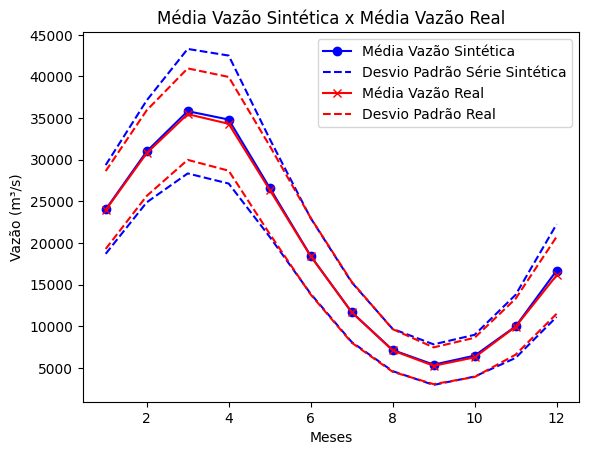

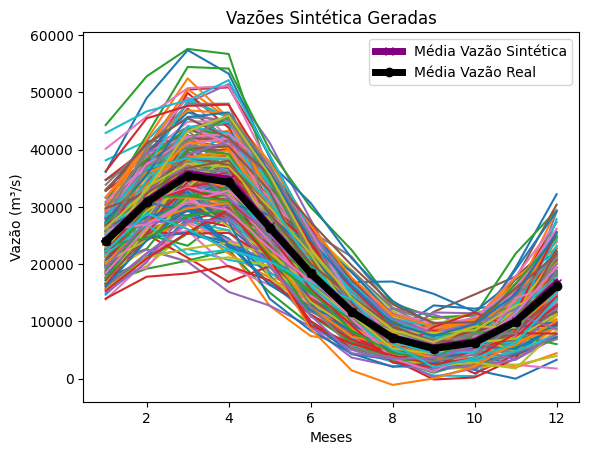

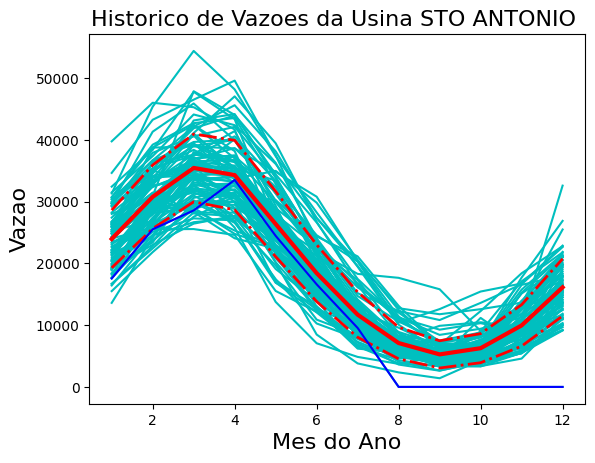

In [14]:
# Número de anos a serem gerados
num_anos = 1

# Número de séries a serem geradas
num_series = 200

# Mês de início da série
mes_atual = 0

# Chama a função para gerar a série sintética
gerar_serie(Usina, AnoAnalisado, mes_atual, num_series, num_anos, melhor_num_meses, matriz_residuos, phi, serie_aleatoria=True,plot_real=True,plot_exp=False)

# Plota os dados históricos a fim de compará-los com a série sintética
plt.figure()
PMOSET2023.confhd.plot_vaz(Usina)

### Caso 2

Está sendo gerado séries sintéticas cinco anos a frente começando em janeiro, com 2000 séries geradas.

Neste caso está sendo utilizado anos aleatórios como dados de entrada para cada série gerada.

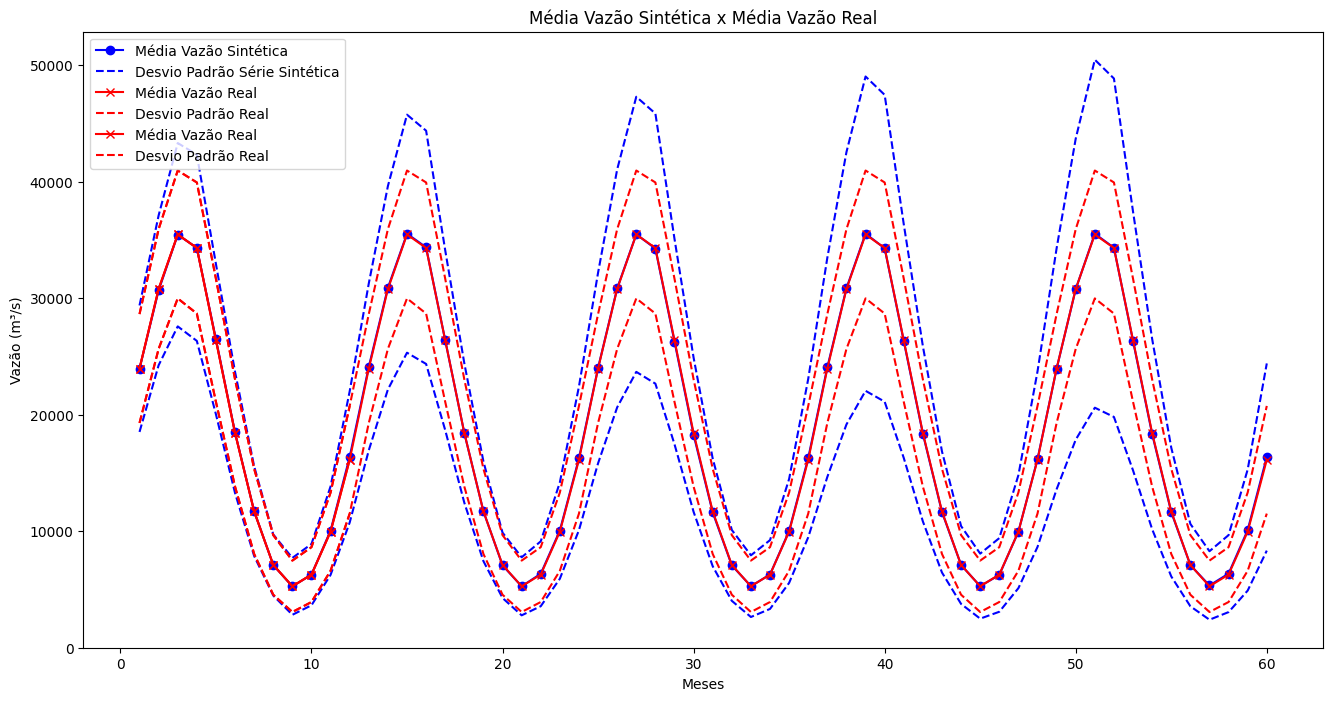

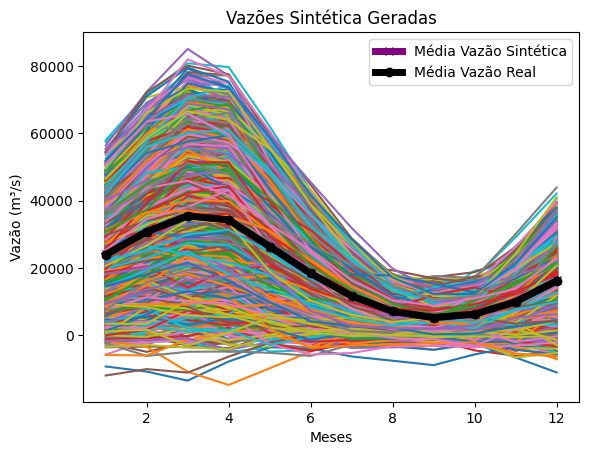

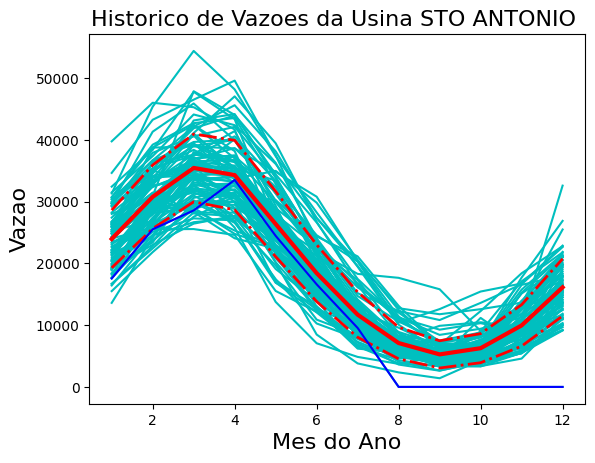

In [15]:
# Número de anos a serem gerados
num_anos = 5

# Número de séries a serem geradas
num_series = 2000

# Mês de início da série
mes_atual = 0

# Chama a função para gerar a série sintética
gerar_serie(Usina, AnoAnalisado, mes_atual, num_series, num_anos, melhor_num_meses, matriz_residuos, phi, serie_aleatoria=True,plot_real=True,plot_exp=True)

# Plota os dados históricos a fim de compará-los com a série sintética
plt.figure()
PMOSET2023.confhd.plot_vaz(Usina)

### Caso 3

Está sendo gerado séries sintéticas cinco anos a frente começando em agosto, com 2000 séries geradas.

Neste caso está sendo utilizado o ano de 2023 como dado de entrada para cada série gerada.

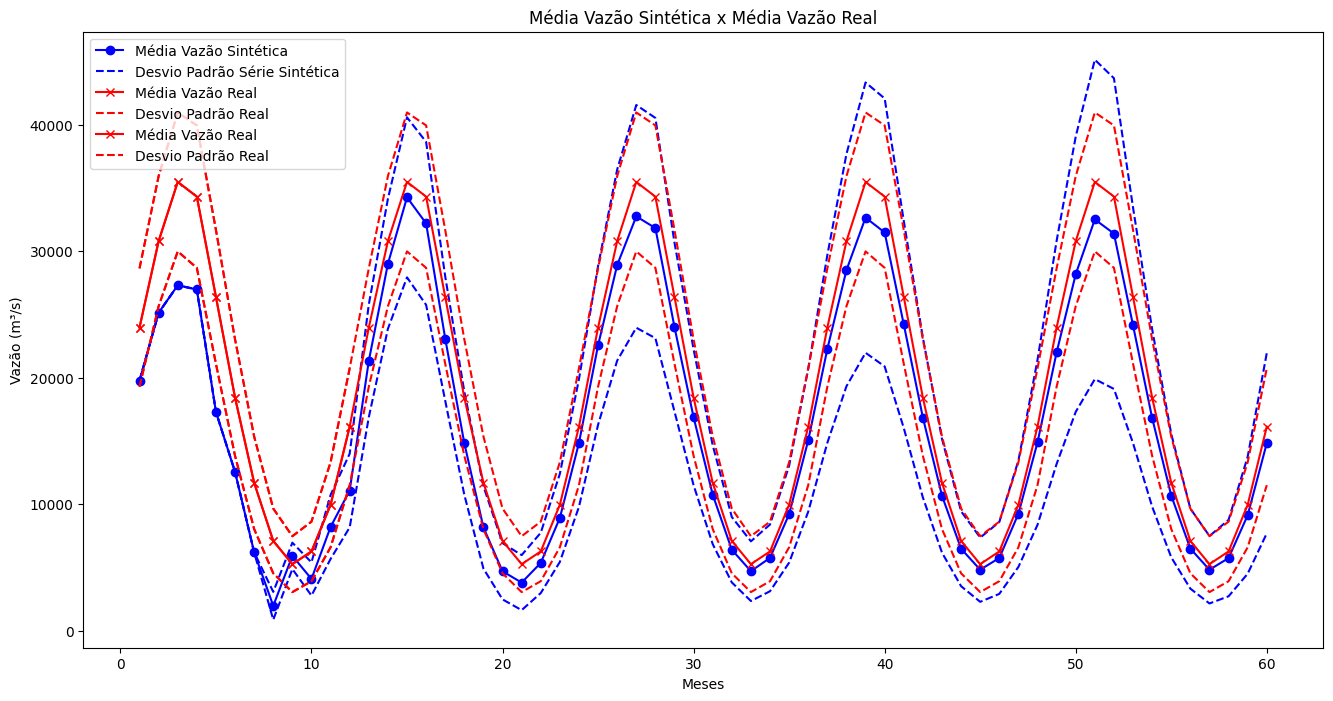

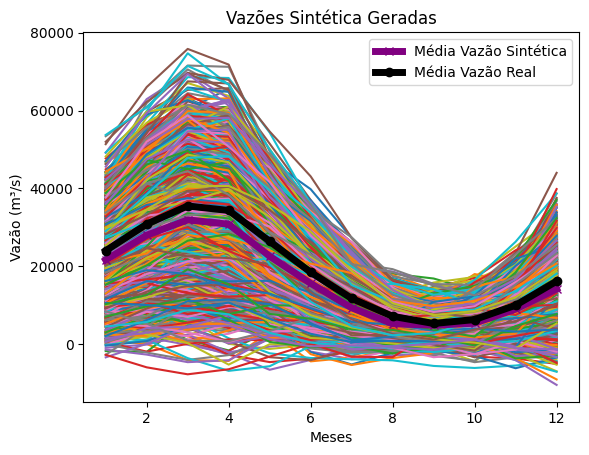

In [16]:
# Ano a ser analisado
AnoAnalisado = 2023

AnoAnalisado = AnoAnalisado - 1931

# Número de anos a serem gerados
num_anos = 5

# Número de séries a serem geradas
num_series = 2000

# Mês de início da série
mes_atual = 7

# Chama a função para gerar a série sintética
gerar_serie(Usina, AnoAnalisado, mes_atual, num_series, num_anos, melhor_num_meses, matriz_residuos, phi, serie_aleatoria=False,plot_real=True,plot_exp=True)